***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 64-D>32-D>16-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\5_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0,1,2,3,4,5,6,7
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')
8 Physical GPUs, 8 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('5_CU_Bird/HD_CapsNet/Mod_3_4')

# Import Dataset : CU BIRD

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [ ]:
model = get_compiled_model()

In [14]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 123)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 200)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 39)           0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 39)          0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 200)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 200)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

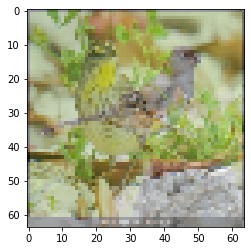

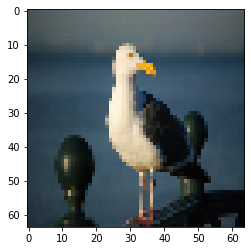

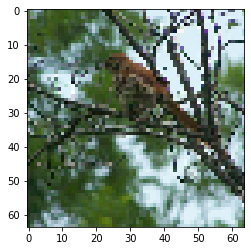

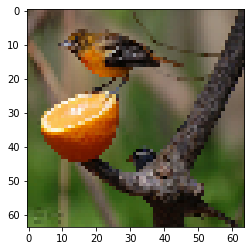

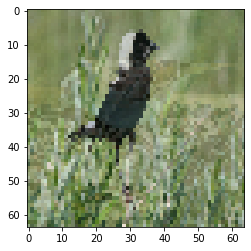

In [16]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.2059 - prediction_medium_accuracy: 0.0792 - prediction_fine_accuracy: 0.0093   
  • Coarse Accuracy = 20.59% | Val_Accuracy = 7.46% | LossWeight = 0.40 
  • Medium Accuracy = 7.92% | Val_Accuracy = 1.62% | LossWeight = 0.35 
  • Fine   Accuracy = 0.93% | Val_Accuracy = 0.69% | LossWeight = 0.25 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00690, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_4\epoch-best.h5
94/94 [==============================] - 503s 4s/step - loss: nan - prediction_coarse_accuracy: 0.2059 - prediction_medium_accuracy: 0.0792 - prediction_fine_accuracy: 0.0093 - val_loss: nan - val_prediction_coarse_accuracy: 0.0746 - val_prediction_medium_accu

Epoch 10/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.8876 - prediction_medium_accuracy: 0.8542 - prediction_fine_accuracy: 0.7276   
  • Coarse Accuracy = 88.76% | Val_Accuracy = 45.70% | LossWeight = 0.31 
  • Medium Accuracy = 85.42% | Val_Accuracy = 29.03% | LossWeight = 0.30 
  • Fine   Accuracy = 72.76% | Val_Accuracy = 20.23% | LossWeight = 0.38 

Epoch 10: val_prediction_fine_accuracy improved from 0.17950 to 0.20228, saving model to ../../logs/5_CU_Bird/HD_CapsNet/Mod_3_4\epoch-best.h5
94/94 [==============================] - 136s 1s/step - loss: nan - prediction_coarse_accuracy: 0.8876 - prediction_medium_accuracy: 0.8542 - prediction_fine_accuracy: 0.7276 - val_loss: nan - val_prediction_coarse_accuracy: 0.4570 - val_prediction_medium_accuracy: 0.2903 - val_prediction_fine_accuracy: 0.2023 - lr: 0.0010
Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9248 - prediction

94/94 [==============================] - 131s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9641 - prediction_medium_accuracy: 0.9655 - prediction_fine_accuracy: 0.9605 - val_loss: nan - val_prediction_coarse_accuracy: 0.4833 - val_prediction_medium_accuracy: 0.3076 - val_prediction_fine_accuracy: 0.2220 - lr: 6.3025e-04
Epoch 20/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9715   
  • Coarse Accuracy = 97.31% | Val_Accuracy = 47.98% | LossWeight = 0.45 
  • Medium Accuracy = 97.53% | Val_Accuracy = 29.96% | LossWeight = 0.31 
  • Fine   Accuracy = 97.15% | Val_Accuracy = 22.30% | LossWeight = 0.24 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 129s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9715 - val_loss: nan - v

94/94 [==============================] - 143s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9736 - prediction_medium_accuracy: 0.9716 - prediction_fine_accuracy: 0.9701 - val_loss: nan - val_prediction_coarse_accuracy: 0.4726 - val_prediction_medium_accuracy: 0.3114 - val_prediction_fine_accuracy: 0.2220 - lr: 3.7735e-04
Epoch 30/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9746 - prediction_fine_accuracy: 0.9728   
  • Coarse Accuracy = 97.56% | Val_Accuracy = 46.39% | LossWeight = 0.43 
  • Medium Accuracy = 97.46% | Val_Accuracy = 29.58% | LossWeight = 0.33 
  • Fine   Accuracy = 97.28% | Val_Accuracy = 21.71% | LossWeight = 0.24 

Epoch 30: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 139s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9746 - prediction_fine_accuracy: 0.9728 - val_loss: nan - v

94/94 [==============================] - 124s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9746 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9751 - val_loss: nan - val_prediction_coarse_accuracy: 0.4736 - val_prediction_medium_accuracy: 0.3038 - val_prediction_fine_accuracy: 0.2195 - lr: 2.2594e-04
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9761 - prediction_medium_accuracy: 0.9721 - prediction_fine_accuracy: 0.9723   
  • Coarse Accuracy = 97.61% | Val_Accuracy = 48.05% | LossWeight = 0.41 
  • Medium Accuracy = 97.21% | Val_Accuracy = 30.24% | LossWeight = 0.35 
  • Fine   Accuracy = 97.23% | Val_Accuracy = 21.88% | LossWeight = 0.24 

Epoch 40: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 126s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9761 - prediction_medium_accuracy: 0.9721 - prediction_fine_accuracy: 0.9723 - val_loss: nan - v

94/94 [==============================] - 166s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9770 - prediction_medium_accuracy: 0.9763 - prediction_fine_accuracy: 0.9745 - val_loss: nan - val_prediction_coarse_accuracy: 0.4736 - val_prediction_medium_accuracy: 0.3007 - val_prediction_fine_accuracy: 0.2206 - lr: 1.3528e-04
Epoch 50/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9746 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.9721   
  • Coarse Accuracy = 97.46% | Val_Accuracy = 47.53% | LossWeight = 0.43 
  • Medium Accuracy = 97.40% | Val_Accuracy = 30.72% | LossWeight = 0.33 
  • Fine   Accuracy = 97.21% | Val_Accuracy = 21.44% | LossWeight = 0.24 

Epoch 50: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 132s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9746 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.9721 - val_loss: nan - v

94/94 [==============================] - 130s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9750 - prediction_medium_accuracy: 0.9760 - prediction_fine_accuracy: 0.9738 - val_loss: nan - val_prediction_coarse_accuracy: 0.4767 - val_prediction_medium_accuracy: 0.3062 - val_prediction_fine_accuracy: 0.2182 - lr: 8.0995e-05
Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9798 - prediction_fine_accuracy: 0.9761   
  • Coarse Accuracy = 97.78% | Val_Accuracy = 47.95% | LossWeight = 0.45 
  • Medium Accuracy = 97.98% | Val_Accuracy = 30.34% | LossWeight = 0.30 
  • Fine   Accuracy = 97.61% | Val_Accuracy = 21.30% | LossWeight = 0.24 

Epoch 60: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 131s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9798 - prediction_fine_accuracy: 0.9761 - val_loss: nan - v

94/94 [==============================] - 138s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9766 - prediction_medium_accuracy: 0.9763 - prediction_fine_accuracy: 0.9748 - val_loss: nan - val_prediction_coarse_accuracy: 0.4774 - val_prediction_medium_accuracy: 0.3062 - val_prediction_fine_accuracy: 0.2168 - lr: 4.8495e-05
Epoch 70/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9761 - prediction_fine_accuracy: 0.9736   
  • Coarse Accuracy = 97.41% | Val_Accuracy = 47.88% | LossWeight = 0.46 
  • Medium Accuracy = 97.61% | Val_Accuracy = 30.31% | LossWeight = 0.31 
  • Fine   Accuracy = 97.36% | Val_Accuracy = 21.54% | LossWeight = 0.23 

Epoch 70: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 142s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9761 - prediction_fine_accuracy: 0.9736 - val_loss: nan - v

94/94 [==============================] - 144s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9776 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9751 - val_loss: nan - val_prediction_coarse_accuracy: 0.4857 - val_prediction_medium_accuracy: 0.3034 - val_prediction_fine_accuracy: 0.2123 - lr: 2.9035e-05
Epoch 80/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9768 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9761   
  • Coarse Accuracy = 97.68% | Val_Accuracy = 48.39% | LossWeight = 0.44 
  • Medium Accuracy = 97.65% | Val_Accuracy = 30.34% | LossWeight = 0.33 
  • Fine   Accuracy = 97.61% | Val_Accuracy = 21.33% | LossWeight = 0.23 

Epoch 80: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 146s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9768 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9761 - val_loss: nan - v

94/94 [==============================] - 160s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9786 - prediction_medium_accuracy: 0.9783 - prediction_fine_accuracy: 0.9760 - val_loss: nan - val_prediction_coarse_accuracy: 0.4822 - val_prediction_medium_accuracy: 0.3069 - val_prediction_fine_accuracy: 0.2102 - lr: 1.7385e-05
Epoch 90/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9791 - prediction_medium_accuracy: 0.9791 - prediction_fine_accuracy: 0.9773   
  • Coarse Accuracy = 97.91% | Val_Accuracy = 47.88% | LossWeight = 0.44 
  • Medium Accuracy = 97.91% | Val_Accuracy = 30.69% | LossWeight = 0.32 
  • Fine   Accuracy = 97.73% | Val_Accuracy = 21.06% | LossWeight = 0.24 

Epoch 90: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 164s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9791 - prediction_medium_accuracy: 0.9791 - prediction_fine_accuracy: 0.9773 - val_loss: nan - v

94/94 [==============================] - 138s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9791 - prediction_medium_accuracy: 0.9786 - prediction_fine_accuracy: 0.9751 - val_loss: nan - val_prediction_coarse_accuracy: 0.4822 - val_prediction_medium_accuracy: 0.3048 - val_prediction_fine_accuracy: 0.2137 - lr: 1.0409e-05
Epoch 100/100
94/94 [==============================] - ETA: 0s - loss: nan - prediction_coarse_accuracy: 0.9773 - prediction_medium_accuracy: 0.9781 - prediction_fine_accuracy: 0.9773   
  • Coarse Accuracy = 97.73% | Val_Accuracy = 47.95% | LossWeight = 0.45 
  • Medium Accuracy = 97.81% | Val_Accuracy = 30.48% | LossWeight = 0.32 
  • Fine   Accuracy = 97.73% | Val_Accuracy = 21.09% | LossWeight = 0.23 

Epoch 100: val_prediction_fine_accuracy did not improve from 0.23714
94/94 [==============================] - 150s 1s/step - loss: nan - prediction_coarse_accuracy: 0.9773 - prediction_medium_accuracy: 0.9781 - prediction_fine_accuracy: 0.9773 - val_loss: nan -

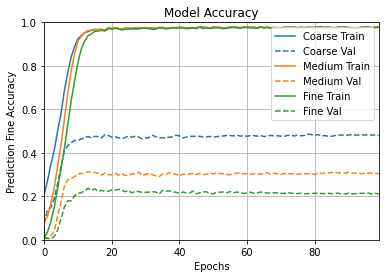

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

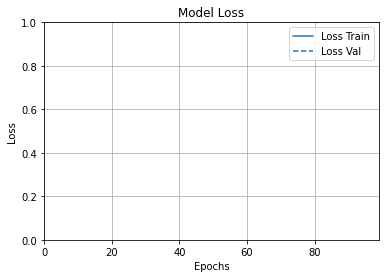

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [23]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/s_caps_medium/Tile' defined at (most recent call last):
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\knoor\AppData\Local\Temp\3/ipykernel_25732/3983783743.py", line 1, in <module>
      results = final_model.evaluate(test_dataset)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\training.py", line 1471, in test_step
      y_pred = self(x, training=False)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\5_CU_BIRD\../..\src\models.py", line 82, in call
      W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1])
Node: 'model/s_caps_medium/Tile'
OOM when allocating tensor with shape[64,167,123,32,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/s_caps_medium/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_376942]

In [ ]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [ ]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [ ]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [ ]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

In [ ]:
metrics.lvl_wise_metric(true_label,pred_label)

In [ ]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )